# Seasonal flu vaccines
This exericse predicts whether individuals will receive their seasonal flu vaccines by fitting machine learning models to the U.S. National 2009 H1N1 Flu Survey data. Data is provided courtesy of the United States National Center for Health Statistics to DrivenData for a practice competition (https://www.drivendata.org/competitions/66/flu-shot-learning/).

In [4]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#model selection/ tuning
from sklearn.model_selection import train_test_split

#deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.layers import Dropout

#performance metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

In [5]:
#suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Data checking and cleaning
In this section, read the csv files into pandas Dataframe and perform any necessary checking and cleaning steps. 

In [6]:
#reading training_set_labels 
df_labels = pd.read_csv("./Resources/training_set_labels.csv", index_col = "respondent_id")
df_labels.head(3)

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0


In [7]:
#reading training_set_features
df_features = pd.read_csv("./Resources/training_set_features.csv", index_col = "respondent_id")
df_features.head(3)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo


In [8]:
#combine both dataframes into a single dataframe
df_vaccine = pd.concat([df_labels,df_features],axis = 1)
df_vaccine.head(3)

,h1n1_vaccine,seasonal_vaccine,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,0,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,0,0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo


In [9]:
#identify h1n1 specific columns
h1n1 = df_vaccine.filter(like = "h1n1").columns
display(h1n1)

#drop h1n1 specific data
df_vaccine.drop(columns = h1n1, inplace = True)

Index(['h1n1_vaccine', 'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc'],
      dtype='object')

In [10]:
#drop columns with more than 40% missing value
df_vaccine.drop(columns = ["health_insurance","employment_industry","employment_occupation"], inplace= True)

## Data Preprocessing
**Review the DataFrame, looking for categorical variables that will need to be encoded, as well as columns that could eventually define your features and target variables.**

In [11]:
df_features = df_vaccine.drop(columns = ["seasonal_vaccine"]).copy()
df_features.head(3)

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,...,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,...,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0


In [12]:
# Create and display the list of numerical variables 
numerical_variables = list(df_features.dtypes[df_features.dtypes != "object"].index)
numerical_variables

['behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [13]:
# Create a list of categorical variables 
categorical_variables = list(df_features.dtypes[df_features.dtypes == "object"].index)

# Display the categorical variables list
categorical_variables

['age_group',
 'education',
 'race',
 'sex',
 'income_poverty',
 'marital_status',
 'rent_or_own',
 'employment_status',
 'hhs_geo_region',
 'census_msa']

**Replacing missing values with most frequent value**

In [14]:
#define strategy for replacing missing values
imp_mostfreq = SimpleImputer(strategy = "most_frequent", missing_values = np.nan)

In [15]:
#replacing missing values
df_numerical_variables_imputed = pd.DataFrame(imp_mostfreq.fit_transform(df_features[numerical_variables].loc[:,:]),
                                              columns = df_features[numerical_variables].columns)

df_numerical_variables_imputed.head(3)

,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0


In [16]:
#replacing missing values
df_categorical_variables_imputed = pd.DataFrame(imp_mostfreq.fit_transform(df_features[categorical_variables].loc[:,:]),
                                   columns = df_features[categorical_variables].columns)

df_categorical_variables_imputed.head(3)

,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA
1,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
2,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City"


**Encode the dataset’s categorical variables using OneHotEncoder, and then place the encoded variables into a new DataFrame.**

In [17]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse = False)

In [18]:
# Encode the categorcal variables using OneHotEncoder
encoded_data = enc.fit_transform(df_categorical_variables_imputed)

In [19]:
# Create a DataFrame with the encoded variables
encoded_df = pd.DataFrame(encoded_data,
                          columns = enc.get_feature_names_out(categorical_variables)
                         )

# Review the DataFrame
encoded_df.head(3)

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


**Add the original DataFrame’s numerical variables to the DataFrame containing the encoded variables.**

In [20]:
# Add the numerical variables from the original DataFrame to the one-hot encoding DataFrame
encoded_df = pd.concat([encoded_df, df_numerical_variables_imputed], axis = 1)

# Review the Dataframe
encoded_df.head(3)

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0


**Define features and target variables**

In [21]:
#define features set X
X = encoded_df.copy()

# Review the features DataFrame
X.head(3)

,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,...,behavioral_touch_face,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,4.0,2.0,4.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,4.0,1.0,2.0,2.0,0.0


In [22]:
#define target variable y
y = df_vaccine["seasonal_vaccine"].copy()
y[:5]

respondent_id
0    0
1    1
2    0
3    1
4    0
Name: seasonal_vaccine, dtype: int64

#### Split dataset into training, validation testing dataset

In [23]:
# Creating training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 10)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 10)

In [24]:
# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

## Build and Train Machine Learning Model

### An alternate ML model: Deep learning model

In [25]:
#seed to random number generator
np.random.seed(1)
tf.random.set_seed(1)

In [26]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

54

In [27]:
# Define the number of neurons in the output layer
number_output_neurons = 1

In [28]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 = (number_input_features + 1)//2

# Review the number hidden nodes in the first layer
hidden_nodes_layer1

27

In [29]:
# Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = (hidden_nodes_layer1 + 1)//2

# Review the number hidden nodes in the second layer
hidden_nodes_layer2

14

In [30]:
# Create the Sequential model instance
nn = Sequential()

In [31]:
# Add the first hidden layer
nn.add(Dense(units = hidden_nodes_layer1, activation = "relu", input_dim = number_input_features))

In [32]:
# Add the second hidden layer
nn.add(Dense(units = hidden_nodes_layer2, activation = "relu"))

In [33]:
# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units = number_output_neurons, activation = "sigmoid"))

In [34]:
# Display the Sequential model summary
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 27)                1485      
                                                                 
 dense_1 (Dense)             (None, 14)                392       
                                                                 
 dense_2 (Dense)             (None, 1)                 15        
                                                                 
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Compile the Sequential model
nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics =["accuracy"])

In [36]:
# Fit the model using 50 epochs and the training data
epochs = 50
batch_size = 1000

training_history = nn.fit(X_train_scaled, y_train, validation_data = (X_val_scaled, y_val),
                         epochs = epochs, batch_size = batch_size)

Epoch 1/50
21/21 [==============================] - 2s 22ms/step - loss: 0.6810 - accuracy: 0.5934 - val_loss: 0.6322 - val_accuracy: 0.6485
Epoch 2/50
21/21 [==============================] - 0s 7ms/step - loss: 0.6096 - accuracy: 0.6742 - val_loss: 0.5921 - val_accuracy: 0.6946
Epoch 3/50
21/21 [==============================] - 0s 7ms/step - loss: 0.5726 - accuracy: 0.7117 - val_loss: 0.5643 - val_accuracy: 0.7141
Epoch 4/50
21/21 [==============================] - 0s 7ms/step - loss: 0.5443 - accuracy: 0.7335 - val_loss: 0.5432 - val_accuracy: 0.7345
Epoch 5/50
21/21 [==============================] - 0s 6ms/step - loss: 0.5219 - accuracy: 0.7475 - val_loss: 0.5277 - val_accuracy: 0.7481
Epoch 6/50
21/21 [==============================] - 0s 13ms/step - loss: 0.5064 - accuracy: 0.7586 - val_loss: 0.5175 - val_accuracy: 0.7529
Epoch 7/50
21/21 [==============================] - 0s 8ms/step - loss: 0.4967 - accuracy: 0.7665 - val_loss: 0.5121 - val_accuracy: 0.7557
Epoch 8/50
21/21 [

In [37]:
# Evaluate the nn model
nn.evaluate(X_test_scaled, y_test, verbose=0)

[0.49776628613471985, 0.7642654180526733]

#### Deep Learning Model Performance

In [38]:
# Loss dataframe
loss_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["loss"],
        "Val": training_history.history["val_loss"],
    }
)
loss_df.set_index("Epoch", inplace=True)

In [39]:
# Accuracy dataframe
accuracy_df = pd.DataFrame(
    {
        "Epoch": range(1, epochs + 1),
        "Train": training_history.history["accuracy"],
        "Val": training_history.history["val_accuracy"],
    }
)
accuracy_df.set_index("Epoch", inplace=True)

<AxesSubplot:title={'center':'Accuracy'}, xlabel='Epoch'>

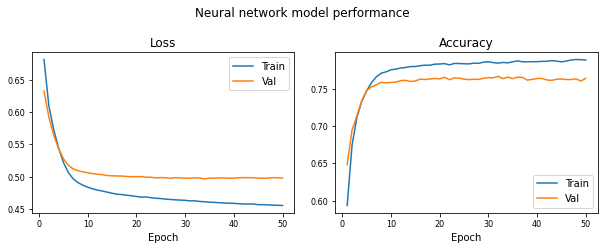

In [40]:
plt.rcParams["figure.figsize"] = [8.5, 3.5]
plt.rcParams["figure.autolayout"] = True

#Plotting loss and accuracy
fig, axes = plt.subplots(1, 2)

#add title
fig.suptitle("Neural network model performance", fontsize = 12)

loss_df.plot(title="Loss", fontsize=8, ax=axes[0])
accuracy_df.plot(title="Accuracy", fontsize=8, ax=axes[1])

In [41]:
# Use the testing data to make the model predictions
y_pred_nn = (nn.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn[:10]

209/209 [==============================] - 1s 2ms/step


array([[1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [42]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn = classification_report(y_test, y_pred_nn,target_names=["No (0)","Yes (1)"])
print(testing_report_nn)

              precision    recall  f1-score   support

      No (0)       0.77      0.78      0.78      3540
     Yes (1)       0.75      0.74      0.75      3137

    accuracy                           0.76      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.76      0.76      6677



In [43]:
#get accuracy score
accuracy_nn = round(accuracy_score(y_test,y_pred_nn),4)
accuracy_nn

0.7643

### Tuning the Deep Learning Model

#### (10th Trial) Deep learning model using:

**Input Features:** 54<br>
**Output Neuron(s):** 1<br>
**Loss:** Binary Crossentropy<br>
**Optimizer:** SGD<br>
**Metrics:** Accuracy<br>
**Epochs:** 150<br>
> *Layer 1*<br>
**Hidden Nodes:** 27<br>
**Activation Function:** Sigmoid<br>
**Dropout Rate:** 0.5<br>

> *Layer 2*<br>
**Hidden Nodes:** 14<br>
**Activation Function:** Sigmoid<br>
**Dropout Rate:** 0.2<br>

> *Layer 3*<br>
**Hidden Nodes:** 7<br>
**Activation Function:** Sigmoid<br>
**Dropout Rate:** 0.2<br>

> *Layer 4*<br>
**Hidden Nodes:** 4<br>
**Activation Function:** Sigmoid<br>

> *Output Layer*<br>
**Activation Function:** Sigmoid

**AUC SCORE:** 0.7628<br>
**Changes from Baseline:**<br>
Optimizer, Adam --> SGD;<br>
Activation functions in layers 1 and 2, ReLu --> Sigmoid;<br>
Addition of hidden layer 3, containing 7 neurons & Sigmoid activation function;<br>
Addition of hidden layer 4, containing 4 neurons & Sigmoid activation function; <br>
Epochs, 50 --> 150<br>
Addition of dropout technique to prevent overfitting, with rate of 0.5 for input layer and 0.2 for layers 2 and 3 (no dropout for layer 4).<br>
**Result:**<br>
Marginally higher AUC score than the baseline.

In [44]:
# Define the number of hidden nodes for the third hidden layer
hidden_nodes_layer3 = (hidden_nodes_layer2 + 1)//2

# Define the number of hidden nodes for the fourth hidden layer
hidden_nodes_layer4 = (hidden_nodes_layer3 + 1)//2

# Review the number hidden nodes in the third layer
hidden_nodes_layer4

4

In [45]:
# Create the Sequential model instance for 10th Trial
nn_t10 = Sequential()

# Add the first hidden layer
nn_t10.add(Dense(units = hidden_nodes_layer1, activation = "sigmoid", input_dim = number_input_features))

# Add the first dropout layer
nn_t10.add(Dropout(0.5))

# Add the second hidden layer
nn_t10.add(Dense(units = hidden_nodes_layer2, activation = "sigmoid"))

# Add the second dropout layer
nn_t10.add(Dropout(0.2))

# Add the third hidden layer
nn_t10.add(Dense(units = hidden_nodes_layer3, activation = "sigmoid"))

# Add the third dropout layer
nn_t10.add(Dropout(0.2))

# Add the fourth hidden layer
nn_t10.add(Dense(units = hidden_nodes_layer4, activation = "sigmoid"))

# Add the output layer to the model specifying the number of output neurons and activation function
nn_t10.add(Dense(units = number_output_neurons, activation = "sigmoid"))

# Display the Sequential model summary
nn_t10.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 27)                1485      
                                                                 
 dropout (Dropout)           (None, 27)                0         
                                                                 
 dense_4 (Dense)             (None, 14)                392       
                                                                 
 dropout_1 (Dropout)         (None, 14)                0         
                                                                 
 dense_5 (Dense)             (None, 7)                 105       
                                                                 
 dropout_2 (Dropout)         (None, 7)                 0         
                                                                 
 dense_6 (Dense)             (None, 4)                

In [46]:
# Compile the Sequential model
nn_t10.compile(loss = "binary_crossentropy", optimizer = "SGD", metrics =["accuracy"])

In [47]:
# Fit the model using 50 epochs and the training data
nn_t10.fit(X_train_scaled, y_train, epochs = 150)

Epoch 1/150
626/626 [==============================] - 3s 3ms/step - loss: 0.6928 - accuracy: 0.5238
Epoch 2/150
626/626 [==============================] - 2s 2ms/step - loss: 0.6922 - accuracy: 0.5257
Epoch 3/150
626/626 [==============================] - 2s 2ms/step - loss: 0.6923 - accuracy: 0.5290
Epoch 4/150
626/626 [==============================] - 1s 2ms/step - loss: 0.6921 - accuracy: 0.5268
Epoch 5/150
626/626 [==============================] - 2s 3ms/step - loss: 0.6914 - accuracy: 0.5312
Epoch 6/150
626/626 [==============================] - 1s 2ms/step - loss: 0.6918 - accuracy: 0.5286
Epoch 7/150
626/626 [==============================] - 2s 3ms/step - loss: 0.6925 - accuracy: 0.5296
Epoch 8/150
626/626 [==============================] - 2s 3ms/step - loss: 0.6919 - accuracy: 0.5314
Epoch 9/150
626/626 [==============================] - 2s 3ms/step - loss: 0.6914 - accuracy: 0.5331
Epoch 10/150
626/626 [==============================] - 2s 3ms/step - loss: 0.6910 - accura

In [48]:
# Use the testing data to make the model predictions
y_pred_nn_t10 = (nn_t10.predict(X_test_scaled) > 0.5).astype("int64")

# Review the model's predicted values
y_pred_nn_t10[:10]

209/209 [==============================] - 1s 2ms/step


array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0]], dtype=int64)

In [49]:
# Use a classification report to evaluate the model using the predictions and testing data
testing_report_nn_t10 = classification_report(y_test, y_pred_nn_t10)
print(testing_report_nn_t10)

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      3540
           1       0.75      0.74      0.75      3137

    accuracy                           0.76      6677
   macro avg       0.76      0.76      0.76      6677
weighted avg       0.76      0.76      0.76      6677



In [50]:
#roc_auc_score
display(roc_auc_score(y_test, y_pred_nn_t10))

0.7628306849719676